In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import cape_expected_returns as cape_er
%matplotlib inline

# Functions for Fitting Curves

In [2]:
getLog = lambda x, a, b: a * np.log(x) + b
getInverse = lambda x, a, b: a * (1/x) + b
getLinear = lambda x, a, b: a * x + b

def getRSquared(df, function, column):
    # Generate coefficients for regression
    x, y = df[column], df.actual
    (a, b), pcov = curve_fit(function, x, y)
    # Get Predictions
    predicted = function(x, a, b)
    # Get Residuals
    residuals = y - predicted
    # Get Residual Sum of Squares
    ss_res = np.sum(residuals ** 2)
    # Get Total Sum of Squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    # Get R Squared
    rSquared = 1 - (ss_res / ss_tot)
    return rSquared, predicted, a, b

# Fit Curve for N Year Time Period

In [3]:
def getScatter(df, column):
    ax1 = df.plot(kind='scatter', x=column, y='actual', color='r')    
    ax2 = df.plot(kind='scatter', x=column, y='predicted', color='g', ax=ax1)

def getYearN(n, plot, table, column, function, real = True):
    # Prepare Data
    asset = table.copy()
    cape_er.addOne(asset, 'Return')
    # Real/Nominal Returns
    if real:
        cape_er.makeReal(asset)
    # Must come after Real, so that index matches inflation's index
    # asset = asset.set_index('Start')
    
    # Get Average return for next n years
    output = []
    inflation2 = []
    limit = len(asset)-n
    for i in range(limit):
        # Geometric mean for i+1 to i+n+1 years
        output.append(asset.Return[i:i+n].product() ** (1/n) - 1)
        inflation2.append(cape_er.inflation.Inflation2[i:i+n].product() ** (1/n) - 1)
    asset = asset[0:limit]
    asset['actual'] = output
    asset['inflation'] = inflation2

    # Get Regression Line and Plot
    rSquared, asset['predicted'], a, b = getRSquared(asset, function, column)
    asset['difference'] = asset.actual - asset.predicted
    if plot:
        getScatter(asset, column)
        fig, ax1 = plt.subplots()
        asset.difference.plot(ax=ax1, style = 'b-')
        ax2 = ax1.twinx()
        asset.actual.plot(ax=ax2, style = 'r-')
        asset.predicted.plot(ax=ax2, style = 'g-')        
        fig.show()
    return rSquared, a, b, asset

# Fit Curve for All Time Periods

In [4]:
printRound = lambda list_: [x.round(4) for x in list_[:-1]]

def getValuation(middle, table, column, function, real = True):
    for i in range(middle-10, middle+10):
        print(i, printRound(getYearN(i, False, table, column, function, real)))
    prediction = getYearN(middle, True, table, column, function, real)
    print(printRound(prediction))
    return prediction[-1]

# Stocks

9 [0.2944, 1.2536, -0.0159]
10 [0.3324, 1.2708, -0.0174]
11 [0.3953, 1.3486, -0.0232]
12 [0.4493, 1.3745, -0.0254]
13 [0.4909, 1.3822, -0.0259]
14 [0.5317, 1.3682, -0.0249]
15 [0.5558, 1.3247, -0.022]
16 [0.5729, 1.2707, -0.0184]
17 [0.6068, 1.2568, -0.0177]
18 [0.6379, 1.2369, -0.0168]
19 [0.6428, 1.1922, -0.0139]
20 [0.6299, 1.1193, -0.0088]
21 [0.6024, 1.0358, -0.0029]
22 [0.5973, 0.9831, 0.0008]
23 [0.5787, 0.9229, 0.0049]
24 [0.5443, 0.8411, 0.0105]
25 [0.4825, 0.7288, 0.0183]
26 [0.4255, 0.6185, 0.0261]
27 [0.3647, 0.5213, 0.0328]
28 [0.3238, 0.4493, 0.0376]
[0.6428, 1.1922, -0.0139]


<ipython-input-3-a6b94837182d>:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


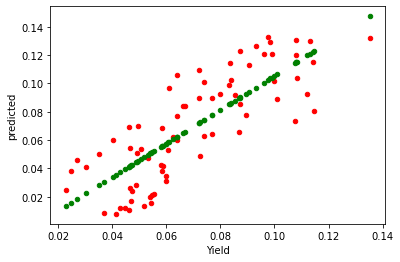

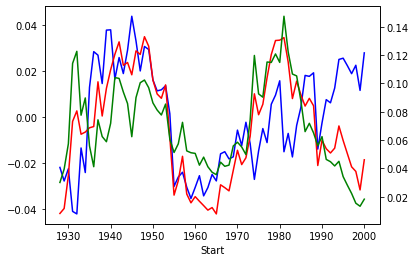

In [5]:
stock = pd.read_excel(cape_er.filename, sheet_name = 'Stock')
stockPrediction = getValuation(19, stock, 'Yield', getLinear, True)

# Bonds

20 [0.8144, 0.044, 0.1497]
21 [0.8372, 0.0434, 0.1482]
22 [0.8575, 0.0427, 0.1461]
23 [0.8839, 0.0424, 0.1453]
24 [0.9033, 0.0419, 0.144]
25 [0.9175, 0.0411, 0.1418]
26 [0.9393, 0.0408, 0.1412]
27 [0.9583, 0.0405, 0.1403]
28 [0.9639, 0.0398, 0.1385]
29 [0.9687, 0.0391, 0.1367]
30 [0.9729, 0.0386, 0.1354]
31 [0.9678, 0.038, 0.1338]
32 [0.9597, 0.0373, 0.1321]
33 [0.9487, 0.0368, 0.1306]
34 [0.9333, 0.036, 0.1285]
35 [0.9128, 0.0353, 0.1266]
36 [0.8847, 0.0347, 0.125]
37 [0.8551, 0.0341, 0.1236]
38 [0.8217, 0.0334, 0.1214]
39 [0.7978, 0.0336, 0.1227]
[0.9729, 0.0386, 0.1354]


<ipython-input-3-a6b94837182d>:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


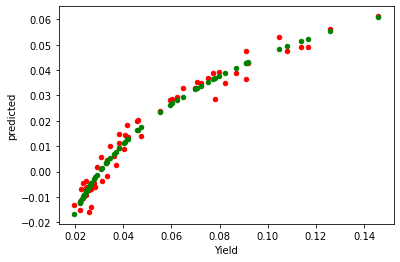

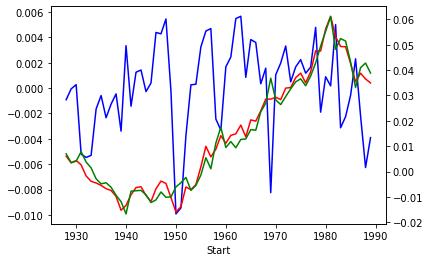

In [6]:
bond = pd.read_excel(cape_er.filename, sheet_name = 'Bond')
bondPrediction = getValuation(30, bond, 'Yield', getLog, real = True)